In [95]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [7]:
img_path = keras.utils.get_file(
    fname='cat.jpg',
    origin='https://img-datasets.s3.amazonaws.com/cat.jpg')
img_path

90112/80329 [=================================] - 0s 3us/step


'C:\\Users\\Butterp\\.keras\\datasets\\cat.jpg'

In [9]:
def get_img_array(image_path, target_size):
    img = keras.utils.load_img(image_path, target_size=target_size)
    img = keras.utils.img_to_array(img)
    return np.expand_dims(img, axis=0) # add batch dim

In [12]:
img_array = get_img_array(img_path, [180,180])
img_array.shape

(1, 180, 180, 3)

(-0.5, 179.5, 179.5, -0.5)

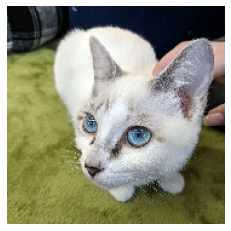

In [16]:
plt.imshow(img_array[0].astype('uint8'))
plt.axis('off')

# look at intermediate activations

In [21]:
layer_outputs, layer_names = [], []
for layer in model.layers:
    if isinstance(layer, (layers.MaxPooling2D, layers.Conv2D)):
        layer_names.append(layer.name)
        layer_outputs.append(layer.output)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [22]:
activations = activation_model.predict(img_array)

In [28]:
first_layer_activation = activations[0]
first_layer_activation.shape

(1, 178, 178, 32)

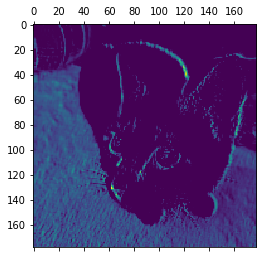

In [44]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')

In [42]:
def plot_all_activations():
    images_per_row = 16
    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros(((size + 1) * n_cols - 1,
                                 images_per_row * (size + 1) - 1))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_index = col * images_per_row + row
                channel_image = layer_activation[0, :, :, channel_index].copy()
                if channel_image.sum() != 0:
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype("uint8")
                display_grid[
                    col * (size + 1): (col + 1) * size + col,
                    row * (size + 1) : (row + 1) * size + row] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.axis("off")
        plt.imshow(display_grid, aspect="auto", cmap="viridis")

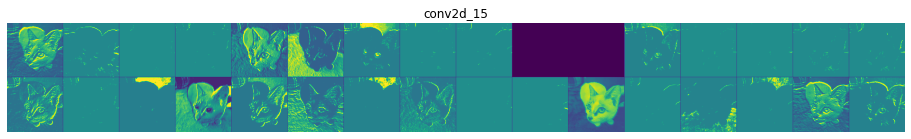

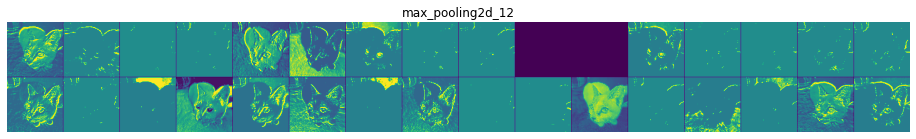

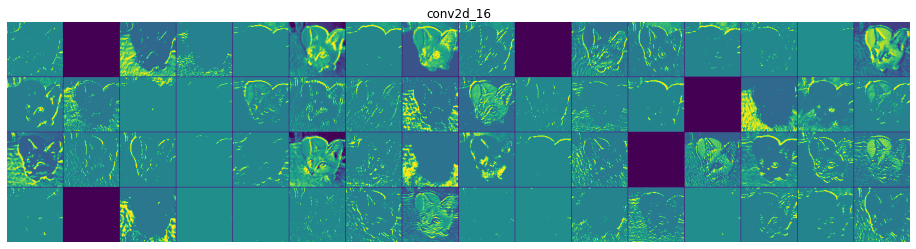

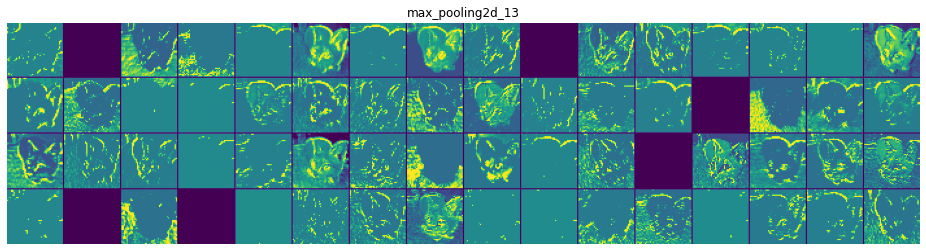

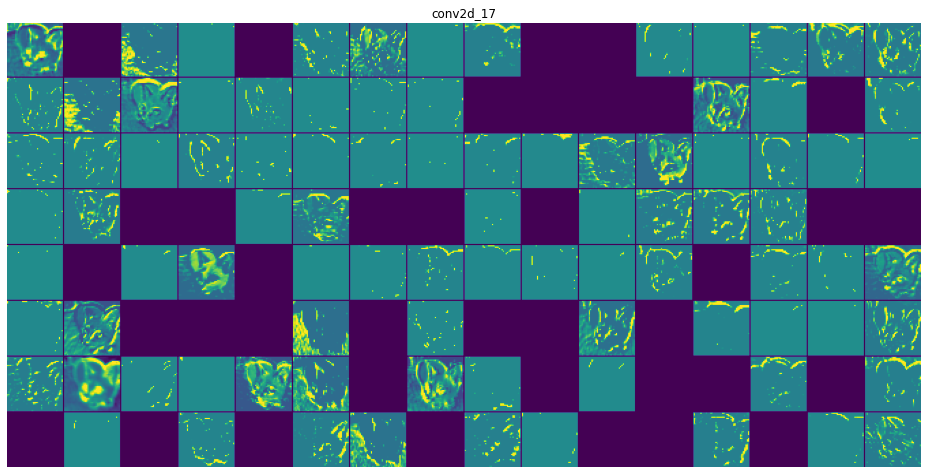

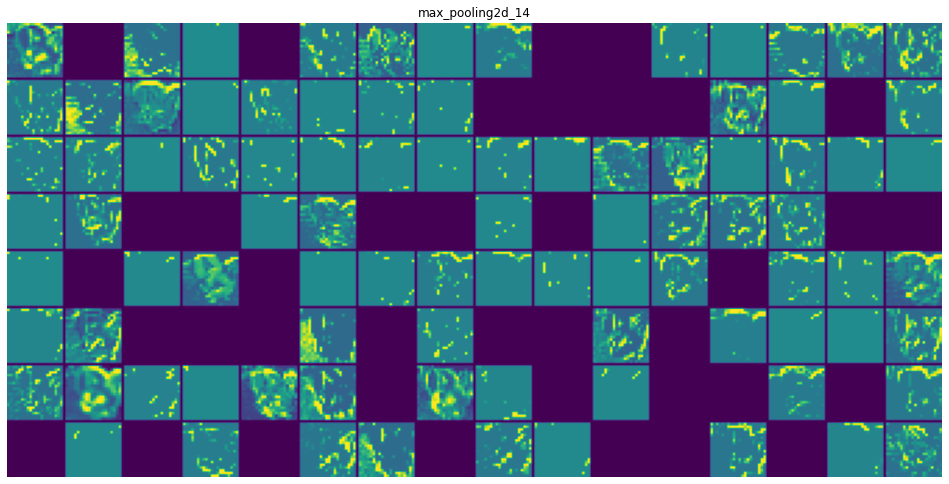

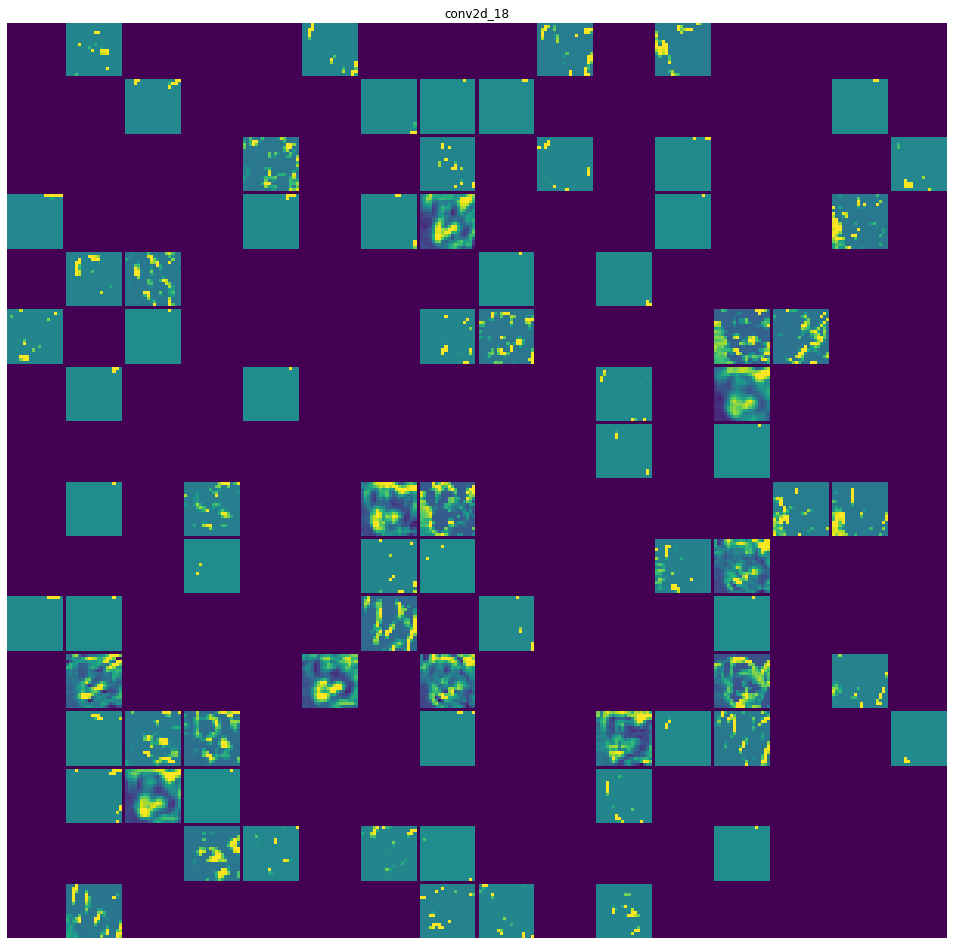

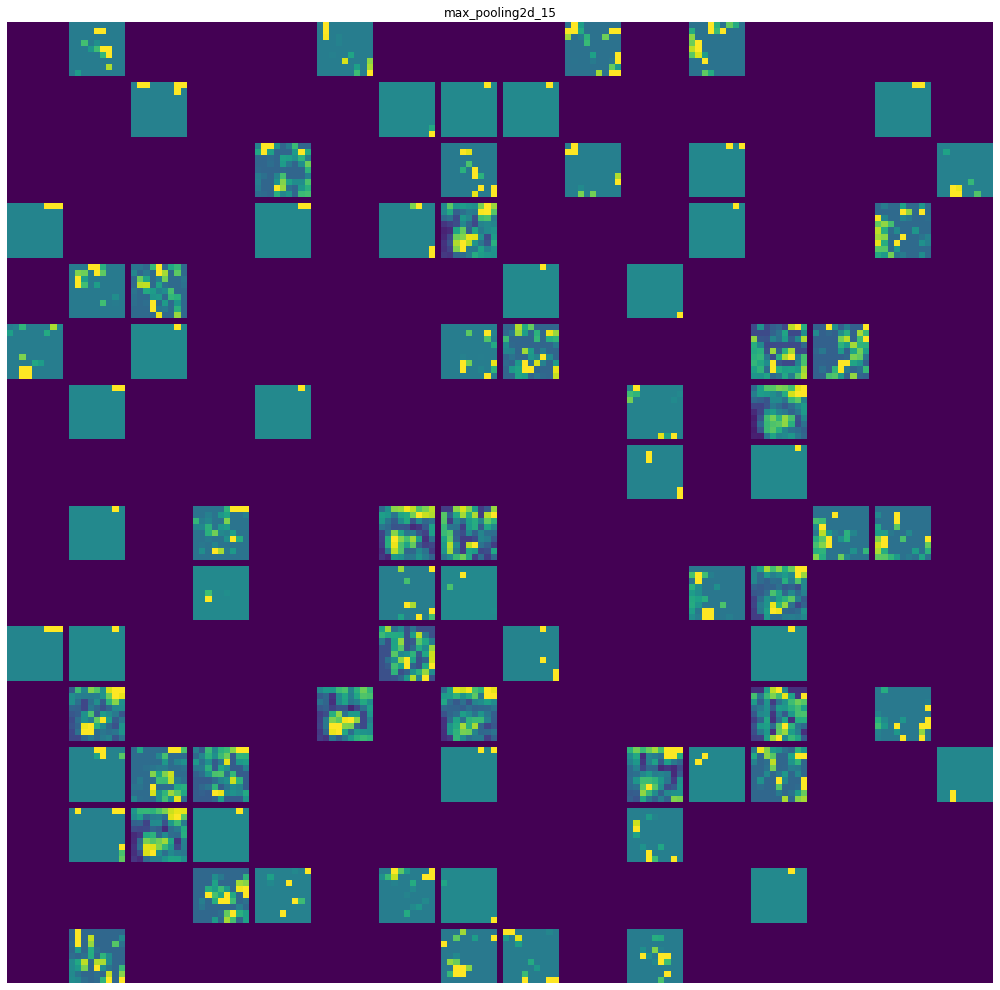

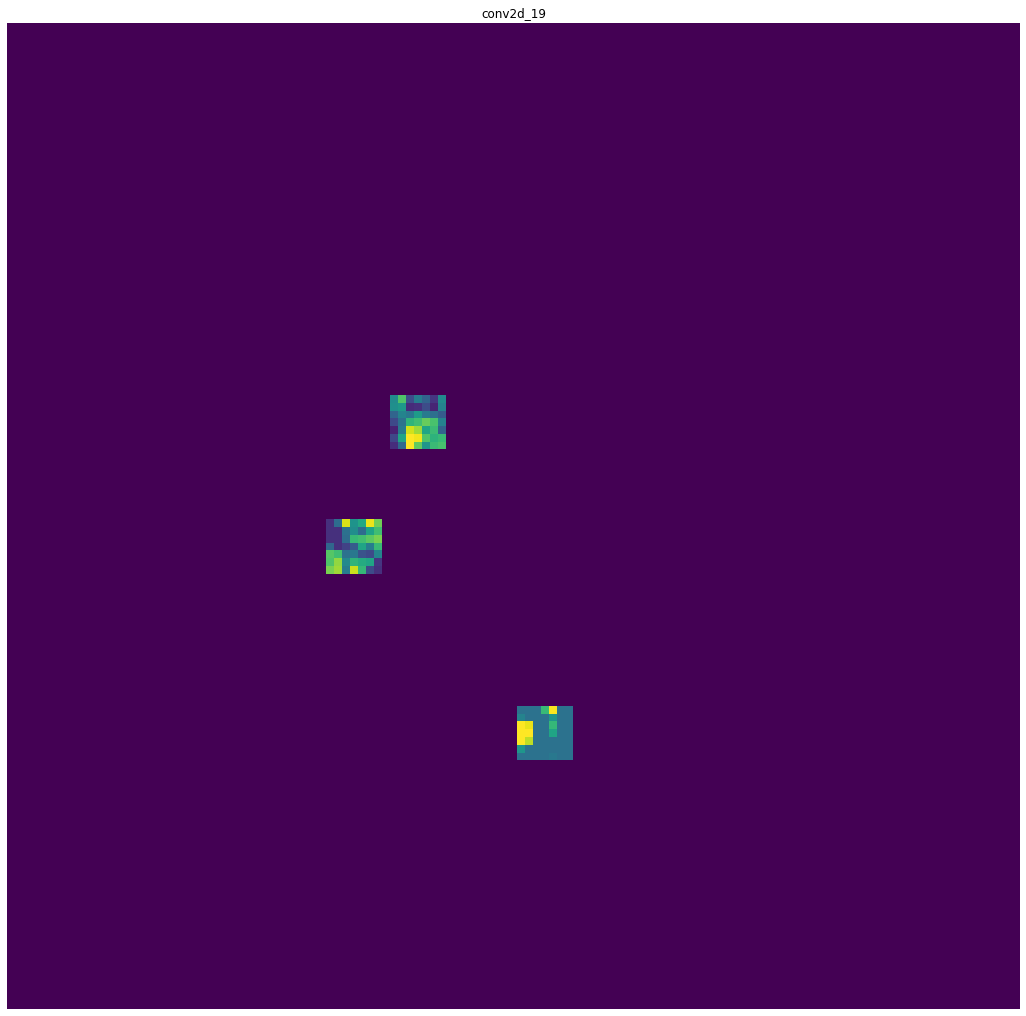

In [43]:
plot_all_activations()

In [8]:
model = keras.models.load_model('models/convnet_from_scratch_with_augmentation.keras')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

# look at filters

In [45]:
model = keras.applications.xception.Xception(include_top=False)

83697664/83683744 [==============================] - 17s 0us/step


In [70]:
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


In [49]:
layer_name = 'block3_sepconv1'
layer = model.get_layer(layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [72]:
# activation = feature_extractor(
#     keras.applications.xception.preprocess_input(img_array))

In [73]:
def compute_loss(image, filter_idx):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_idx]
    return tf.reduce_mean(filter_activation)

In [74]:
@tf.function
def gradient_ascent_step(image, filter_idx, lr):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_idx)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += lr * grads
    return image

In [75]:
image_width, image_height = 200, 200
def generate_filter_pattern(filter_idx):
    iterations = 30
    lr = 10
    image = tf.random.uniform([1, image_width, image_height, 3], minval=0.4, maxval=0.6)
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_idx, lr)
    return image[0].numpy()

In [76]:
filter_pattern = generate_filter_pattern(3)

In [77]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

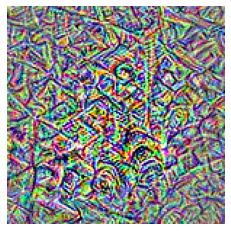

In [78]:
layer = model.get_layer('block14_sepconv1')
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)
plt.axis('off'); plt.imshow(deprocess_image(generate_filter_pattern(2)));

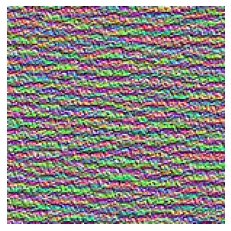

In [65]:
plt.axis('off'); plt.imshow(deprocess_image(generate_filter_pattern(2)));

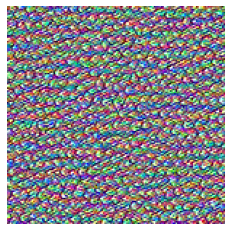

In [64]:
plt.axis('off'); plt.imshow(deprocess_image(generate_filter_pattern(3)));

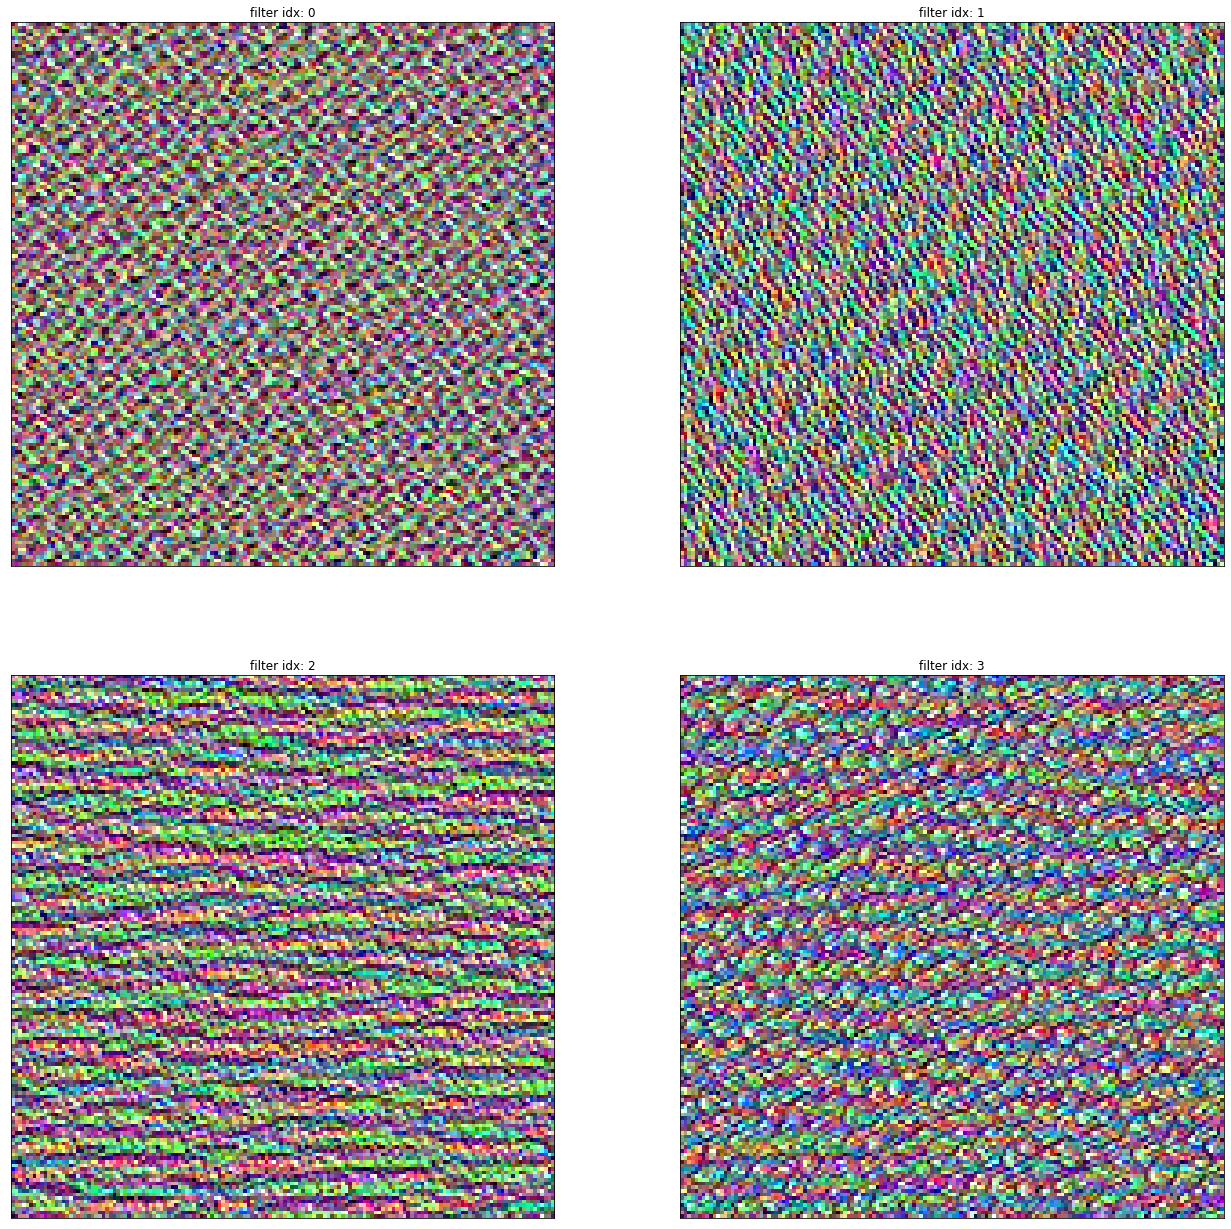

In [66]:
fig = plt.figure(figsize=(22, 22))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, xticks=[], yticks=[])
    ax.imshow(deprocess_image(generate_filter_pattern(i)))
    ax.set_title(f"filter idx: {i}")

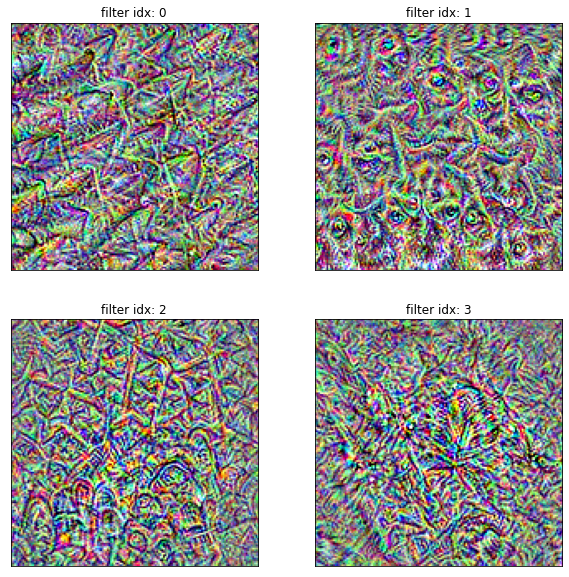

In [79]:
layer = model.get_layer('block8_sepconv1')
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)
fig = plt.figure(figsize=(10, 10))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, xticks=[], yticks=[])
    ax.imshow(deprocess_image(generate_filter_pattern(i)))
    ax.set_title(f"filter idx: {i}")

# class activation map

In [80]:
model = keras.applications.xception.Xception(weights='imagenet')

91897856/91884032 [==============================] - 43s 0us/step


In [81]:
img_path = keras.utils.get_file(fname='elephant.jpg', origin='https://img-datasets.s3.amazonaws.com/elephant.jpg')
img_path

745472/733657 [==============================] - 1s 1us/step


'C:\\Users\\Butterp\\.keras\\datasets\\elephant.jpg'

In [82]:
def get_image_array(image_path, size):
    img = keras.utils.load_img(image_path, target_size=size)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.xception.preprocess_input(img)
    return img

In [84]:
img_array = get_image_array(img_path, [299,299])

In [86]:
# keras.utils.load_img(img_path, [100,100])

In [87]:
preds = model.predict(img_array)
keras.applications.xception.decode_predictions(preds)

49152/35363 [=========================================] - 0s 1us/step


[[('n02504458', 'African_elephant', 0.8699402),
  ('n01871265', 'tusker', 0.07695609),
  ('n02504013', 'Indian_elephant', 0.02354177),
  ('n01704323', 'triceratops', 0.00033701723),
  ('n02113978', 'Mexican_hairless', 0.00020349692)]]

In [89]:
last_conv_layer_name = 'block14_sepconv2_act'
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.input, last_conv_layer.output)
classifier_layer_names = ["avg_pool","predictions",]

In [90]:
classifier_input = keras.Input(shape=last_conv_layer.output_shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [91]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [93]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

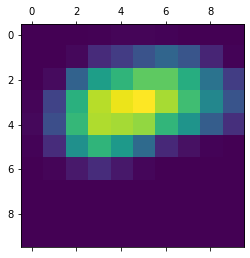

In [94]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap);

In [96]:
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

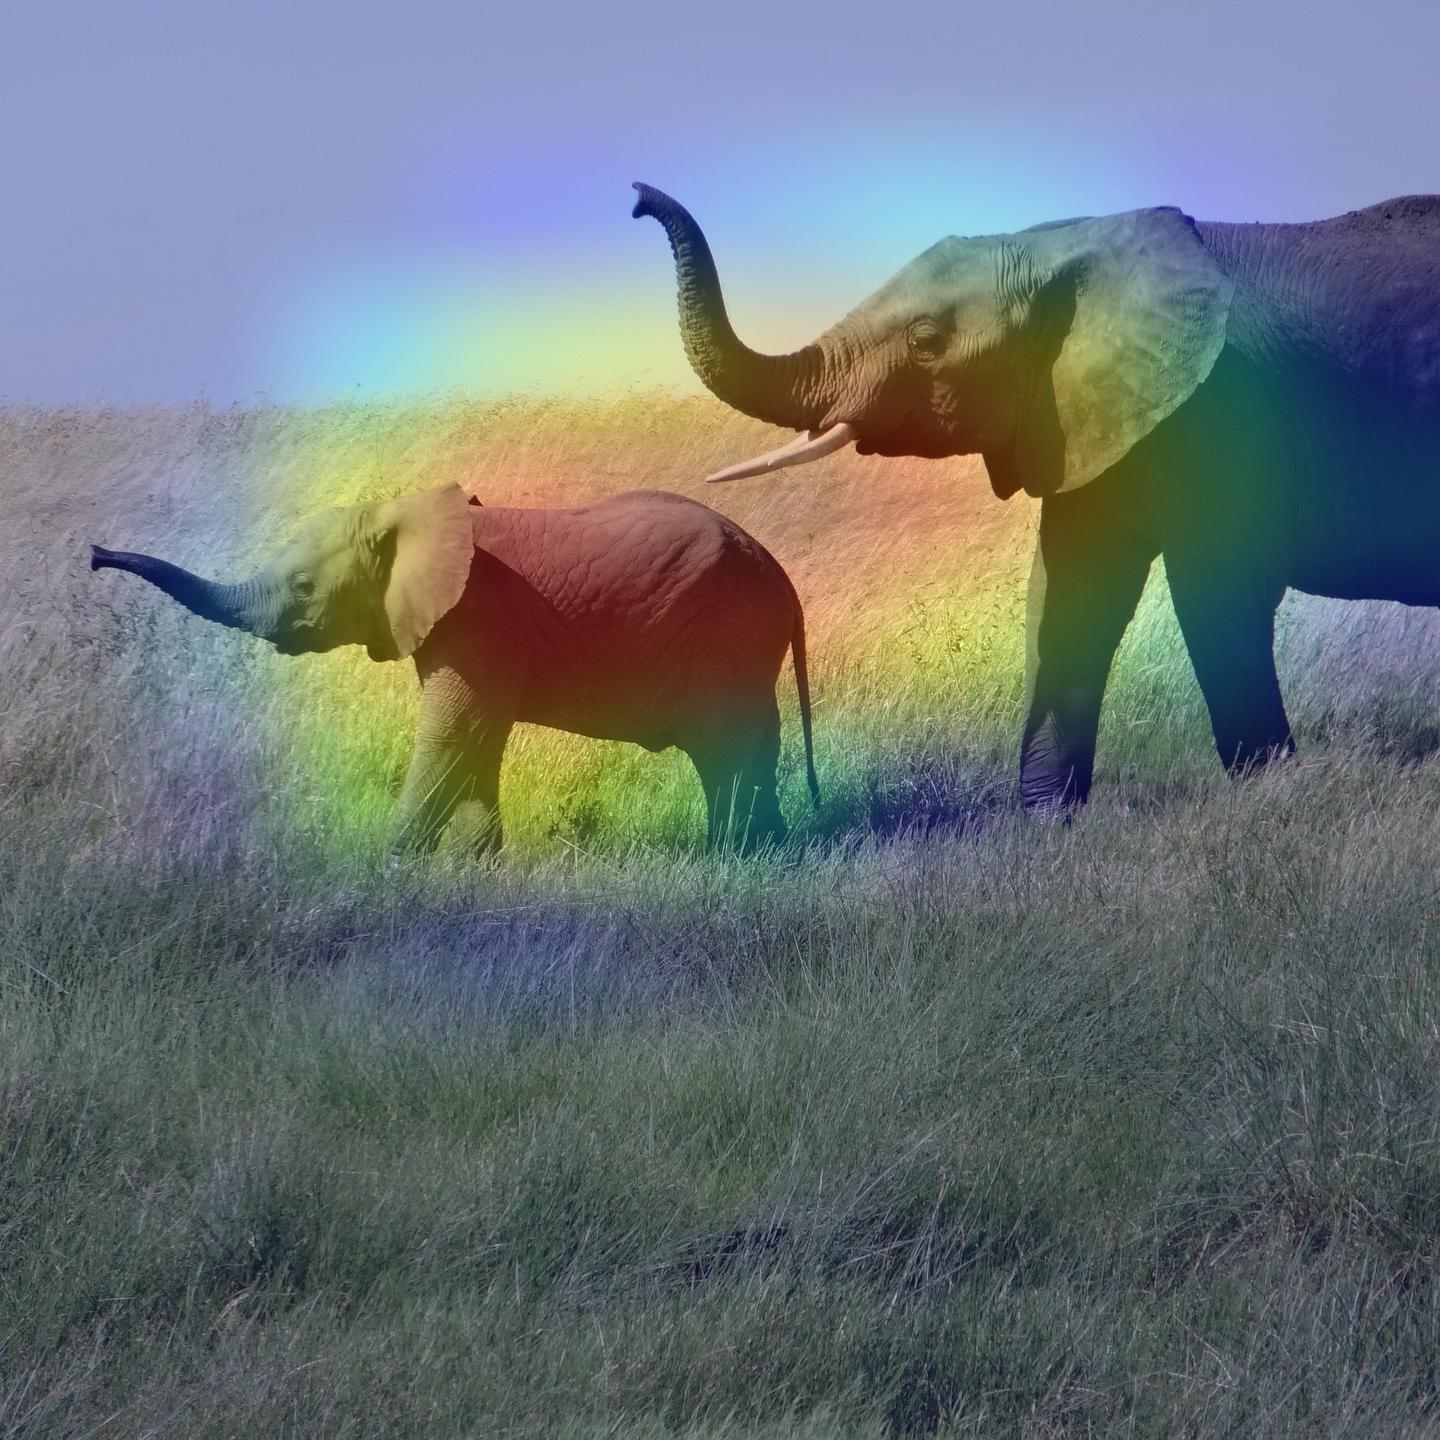

In [97]:
keras.utils.load_img(save_path)